## **프로그래밍 세미나**

- 주제: LSTM (Long Short-Term Memory)
- 발표자: 김지은
- 발표 일자: 2022-01-18(화)


### **0. LSTM 구조**

- Long-term dependencies를 지니는 아키텍쳐
- cell state와 3개의 gate로 구성 

----
네트워크 파라미터 
- f ⊙ c(t-1) : old cell state를 포함시키는 정도를 결정하기 위한 게이트, h(t-1)과 x(t)를 입력 값으로 받아서 1에 가까운 값일수록 많은 정보 기억 
- i ⊙ g : 현재 cell state를 포함시키는 정도를 결정하기 위한 게이트, 이전 게이트 값과 입력 값을 product 연산하여 input gate를 통해 출력 
- f ⊙ c(t-1) + i ⊙ g : old cell state에 i ⊙ g 만큼 정보 추가  
- o ⊙ tanh(c(t)) : 최종 cell state를 hiden state에 포함하는 정도를 결정 

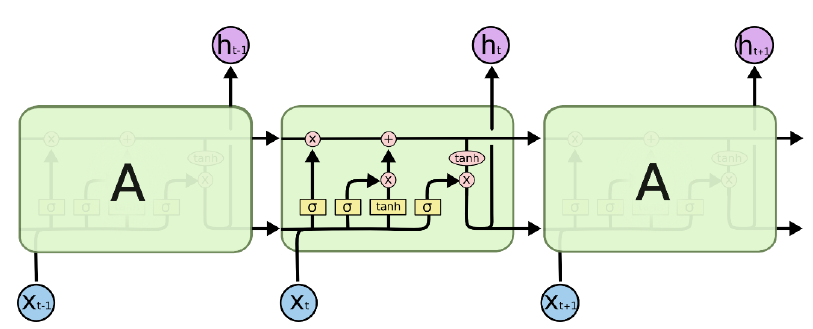

**Timeseries anomaly detection algorithm**

- LSTM + CNN
- LSTM + AE
- LSTM + CNN + AE

### **1. 데이터 설명**

- Timestamp data
- Sensor data(52 series): All values are raw values
- Machine status: This is target label that I want to predict when the failure will happen ('NORMAL', 'BROKEN', 'RECOVERING')
- 출처: https://www.kaggle.com/nphantawee/pump-sensor-data


- **주제: 다변량 시계열 데이터 anomaly score 정의 및 이상구간 탐지**

### **2. 라이브러리 로드** 

In [81]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import easydict
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import pickle
from typing import List

### **3. 데이터 전처리** 

**3.1. 정상, 비정상 데이터 구분**

- 데이터 분할
- 데이터 정규화 

In [13]:
df = pd.read_csv("/content/sensor.csv")

In [3]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


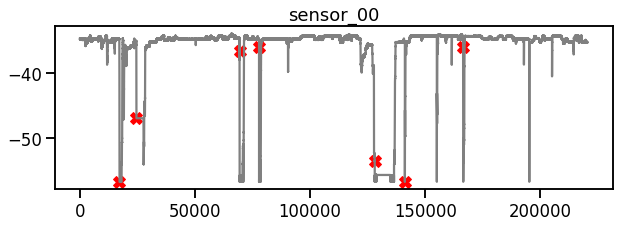

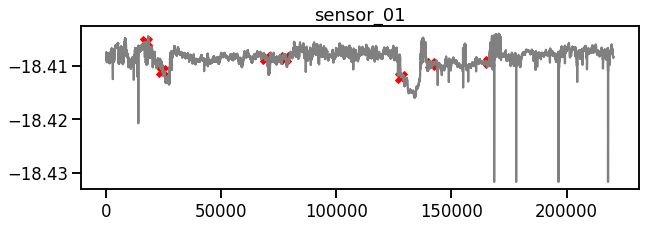

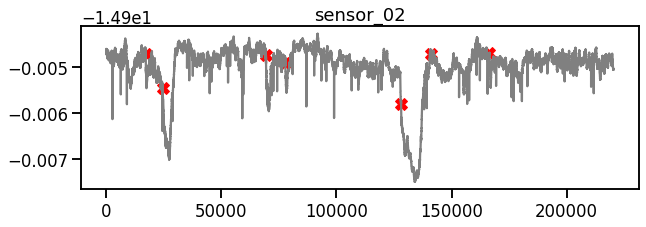

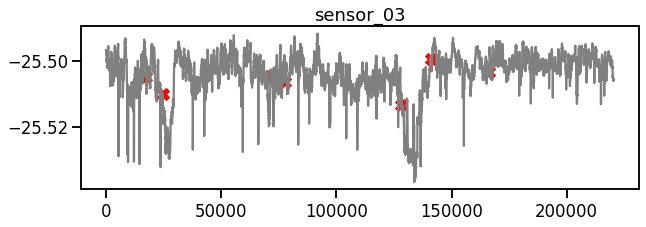

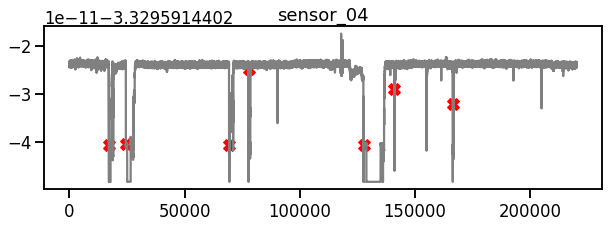

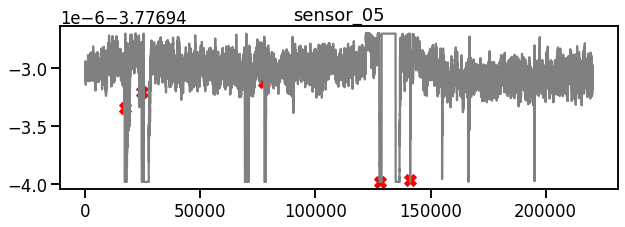

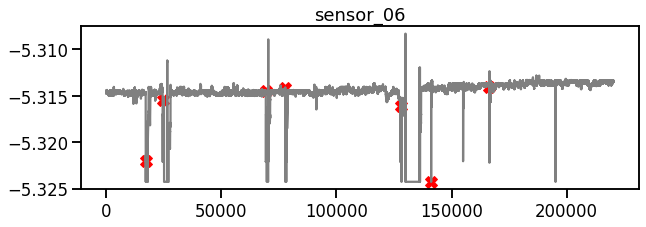

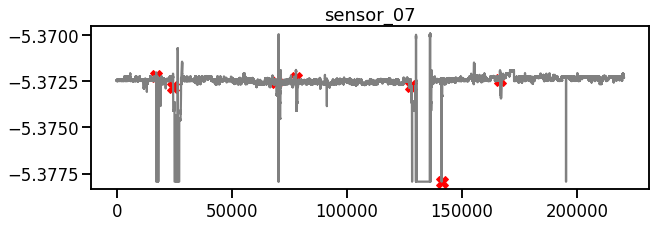

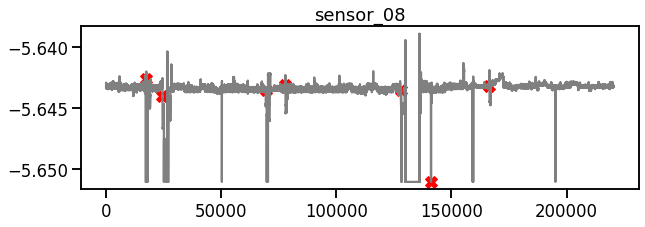

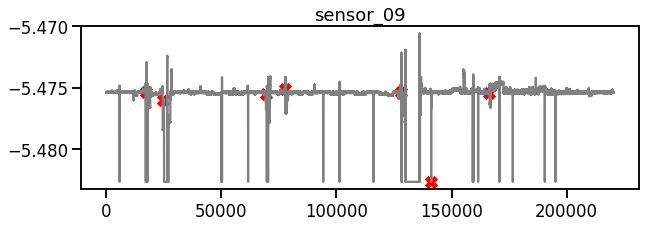

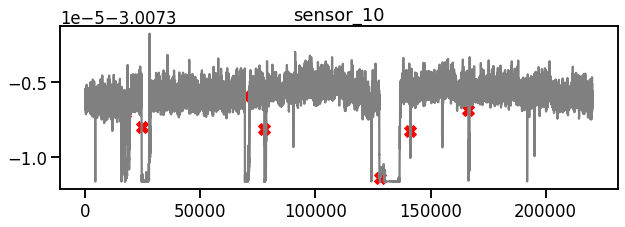

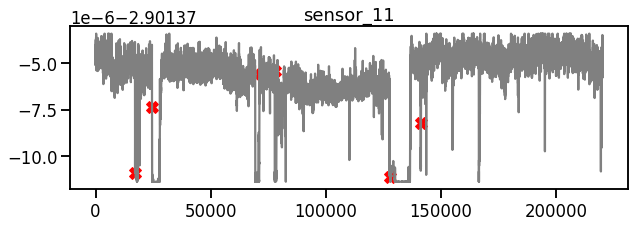

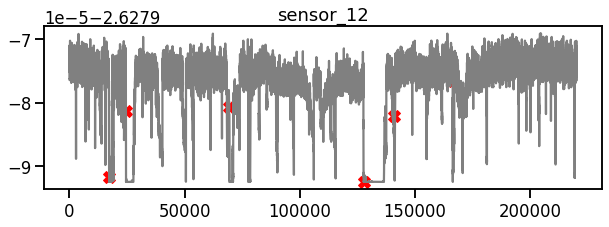

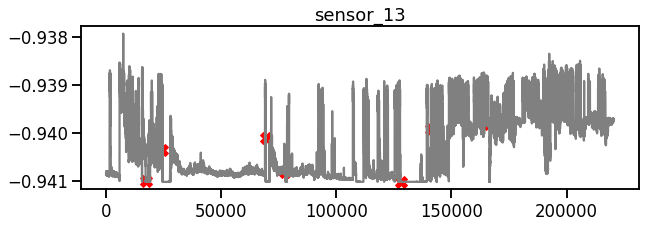

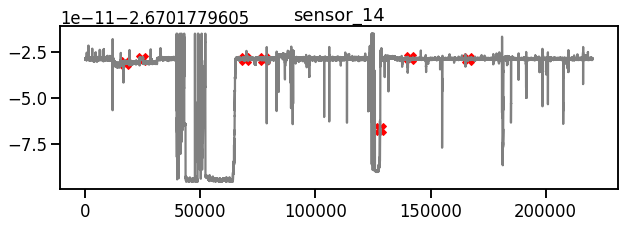

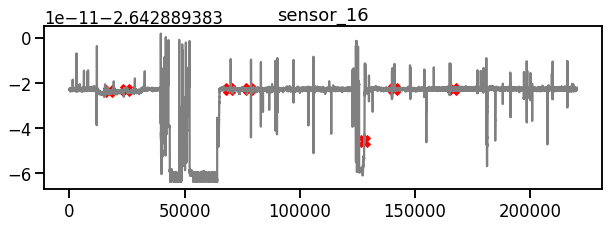

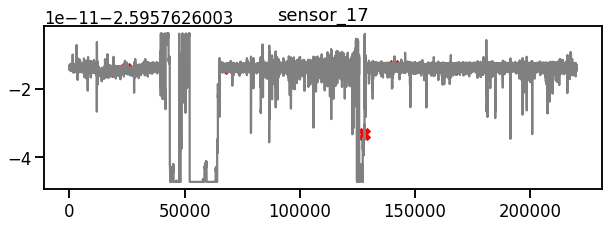

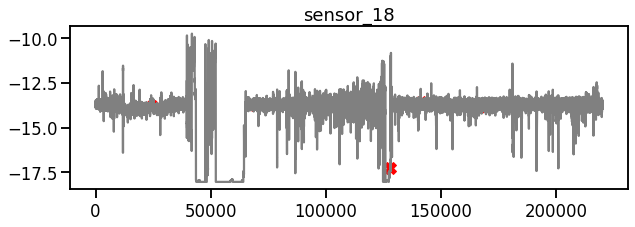

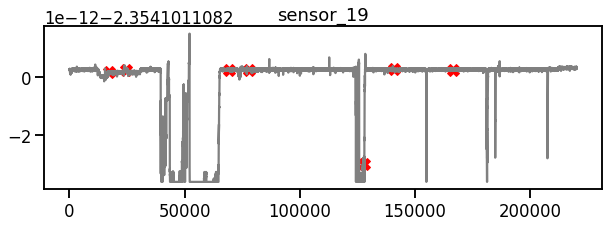

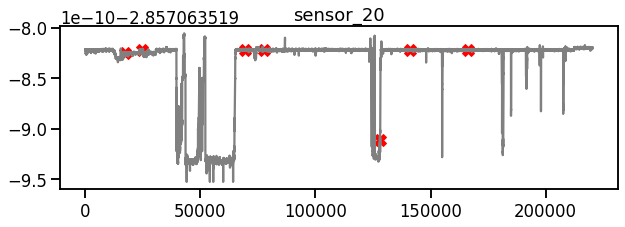

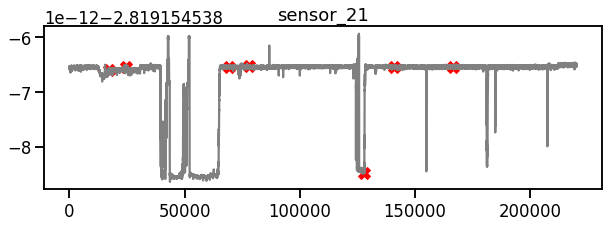

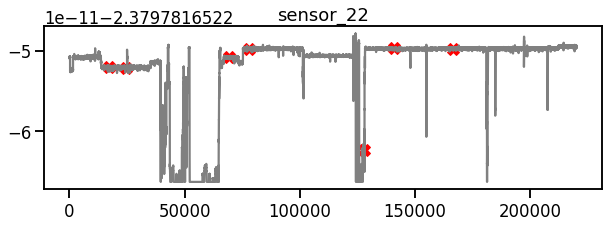

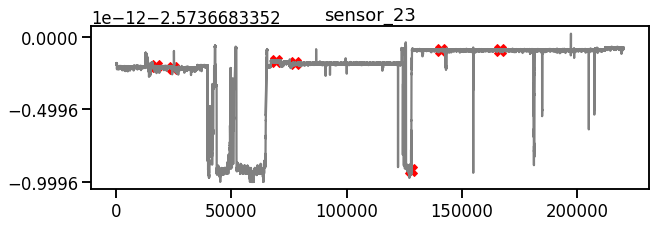

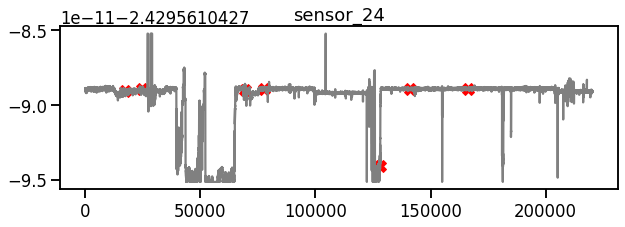

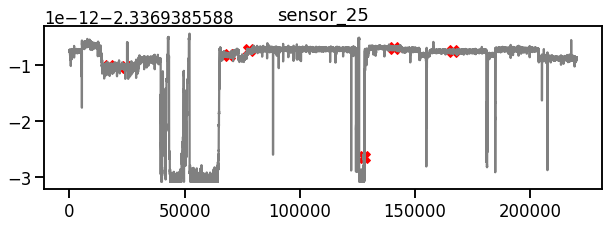

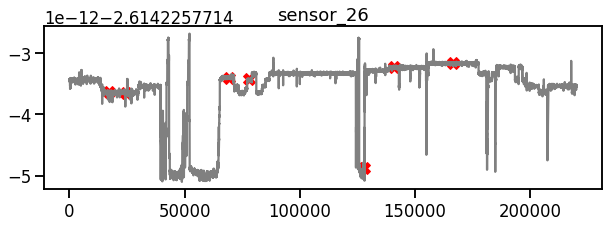

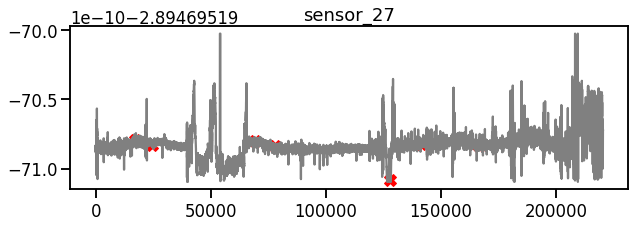

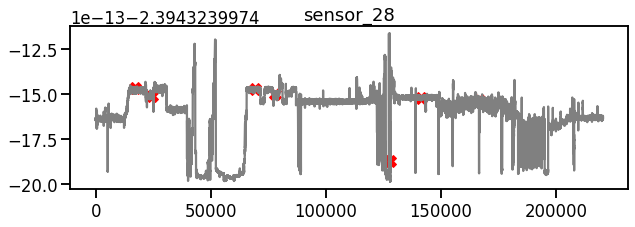

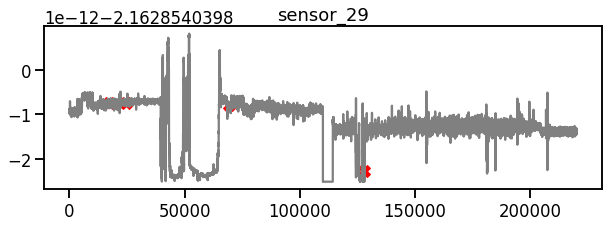

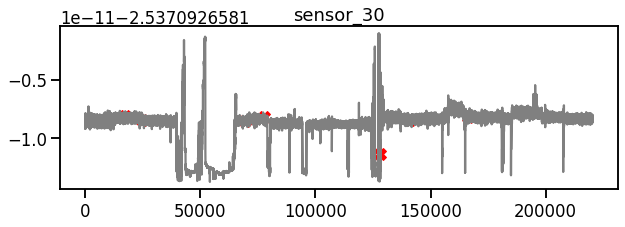

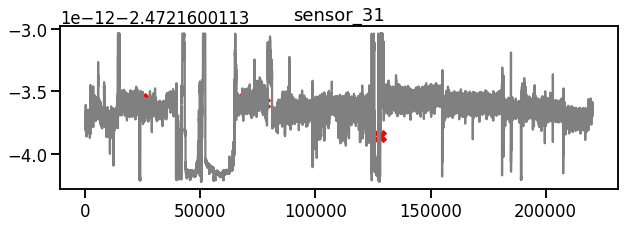

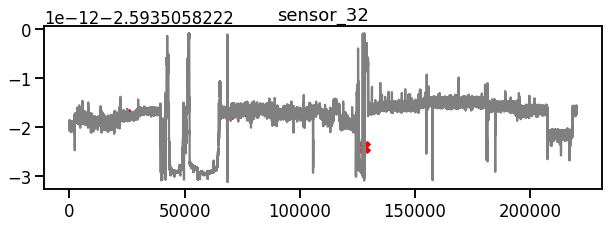

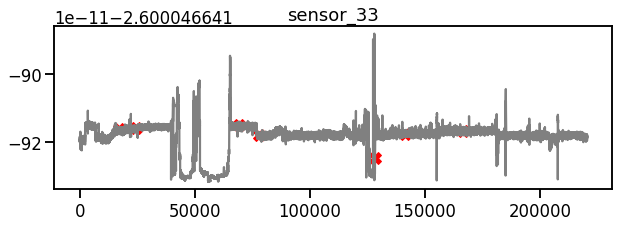

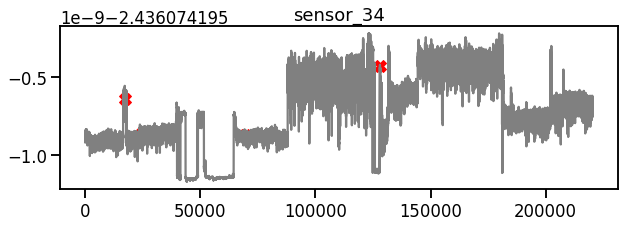

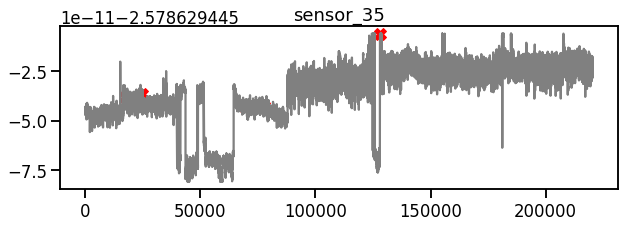

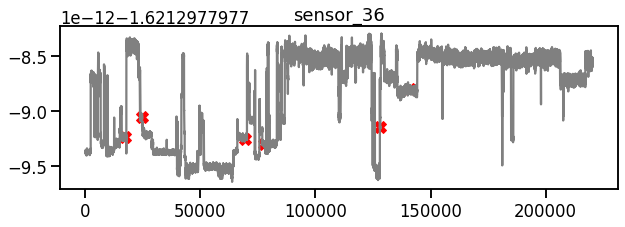

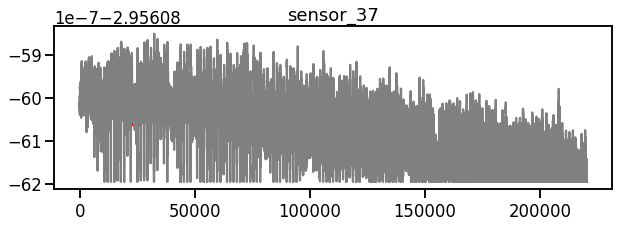

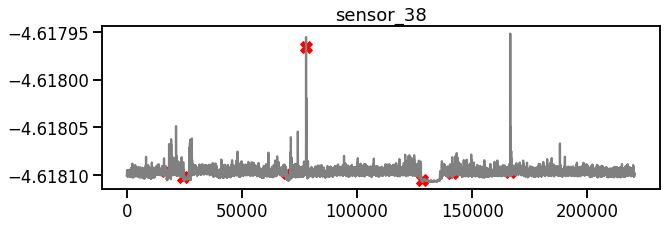

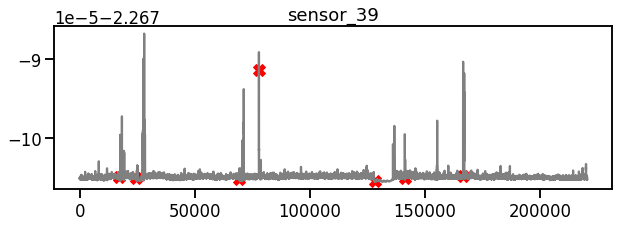

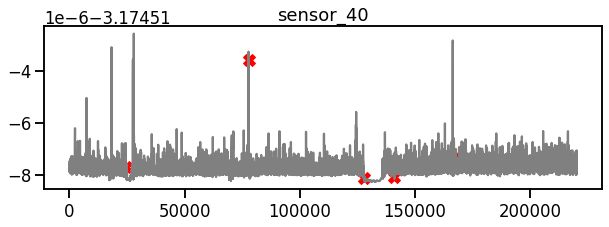

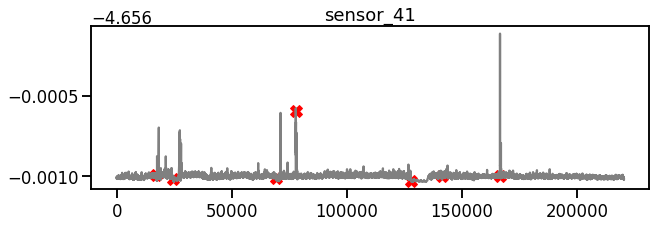

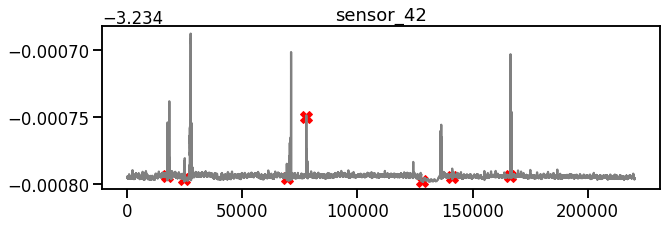

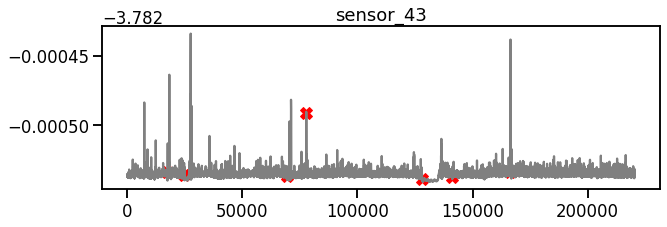

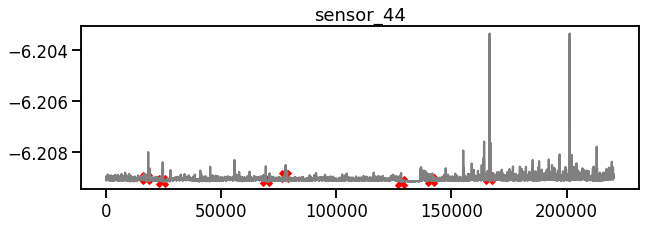

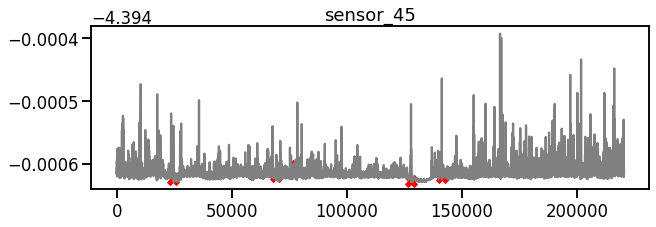

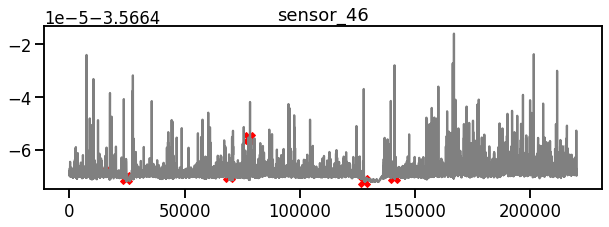

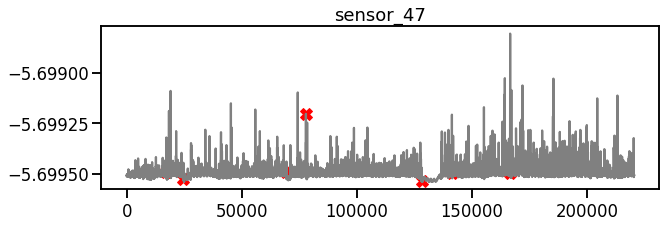

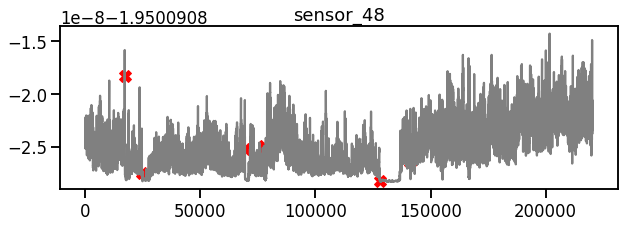

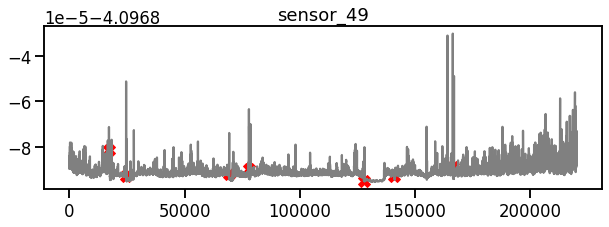

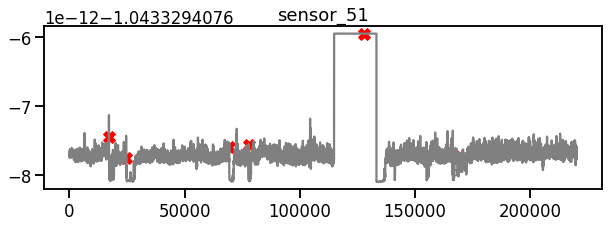

In [79]:
## 데이터 시각화 

Broken = df[df['machine_status']=='BROKEN']
Sensors = df.drop(['machine_status', 'date'], axis=1)
sensorNames = Sensors.columns

for sensor in sensorNames:
    sns.set_context('talk')
    _ = plt.figure(figsize = (10,3))
    _ = plt.plot(Broken[sensor], linestyle = 'none', marker = 'X', color = 'red', markersize = 12)
    _ = plt.plot(df[sensor], color='grey')
    _ = plt.title(sensor)
    plt.show()


In [51]:
## 데이터 Type 변경

# 시계열 특성을 지닌 type으로 변경 
df['date'] = pd.to_datetime(df['timestamp'])

# 수치형 변수로 변경 
for var_index in [item for item in df.columns if 'sensor_' in item]:
    df[var_index] = pd.to_numeric(df[var_index], errors='coerce')

del df['timestamp']

## date를 index로 변환
df = df.set_index('date')
df = df.reset_index()

In [52]:
# 중복된 데이터 삭제
df = df.drop_duplicates()

# 결측치 수 기준으로 센서 15번, 센서 50 은 삭제
del df['sensor_15']
del df['sensor_50']
del df['Unnamed: 0']

# 이전 시점의 데이터로 보간
df = df.fillna(method = 'ffill')

In [53]:
df['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [7]:
# 정상, 비정상 데이터 구분 

normal_df = df[df['machine_status']=='NORMAL']
abnormal_df = df[df['machine_status']!='NORMAL']

In [9]:
# Normal 데이터: 학습데이터, 파라미터 설정데이터, 검증용데이터, 실험용데이터 비율을 7:1:1:1로 나누어서 사용
interval_n = int(len(normal_df)/10)
normal_df1 = df.iloc[0:interval_n*7]
normal_df2 = df.iloc[interval_n*7:interval_n*8]
normal_df3 = df.iloc[interval_n*8:interval_n*9]
normal_df4 = df.iloc[interval_n*9:]

# abnormal 데이터: 검증용데이터, 실험용데이터 비율을 5:5 로 나누어서 사용
interval_ab = int(len(abnormal_df)/2)
abnormal_df1 = df.iloc[0:interval_ab]
abnormal_df2 = df.iloc[interval_ab:]

In [10]:
normal_df1.head()

,date,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


In [11]:
# 데이터 정규화를 위하여 분산 및 평균 추출
mean_df = normal_df1.mean()
std_df = normal_df1.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [12]:
# 시간 변수 기준으로 데이터 간격 확인
def make_data_idx(dates, window_size = 1):
    input_idx = []
    for idx in range(window_size-1, len(dates)):
        cur_date = dates[idx].to_pydatetime()
        in_date = dates[idx - (window_size-1)].to_pydatetime()
        
        _in_period = (cur_date - in_date).days * 24 * 60 + (cur_date - in_date).seconds / 60
        
        # index가 1분 간격으로 저장된 데이터 load
        if _in_period == (window_size - 1):
            input_idx.append(list(range(idx - window_size+1, idx+1)))
    return input_idx

**3.2. 데이터 로더 정의**

In [14]:
## Dataset을 상속받아 데이터를 구성
class TagDataset(Dataset):
    def __init__(self, input_size, df, mean_df = None, std_df = None, window_size = 1):
        
        # 변수 개수
        self.input_size = input_size
        
        # sequence 길이
        self.window_size = window_size
        
        original_df = df.copy()
        
        # 정규화
        if mean_df is not None and std_df is not None:
            sensor_columns = [item for item in df.columns if 'sensor_' in item]
            df[sensor_columns] = (df[sensor_columns] - mean_df)/std_df
        
        dates = list(df['date'])
        self.input_ids = make_data_idx(dates, window_size = window_size)
        
        # sensor 데이터만 사용하여 reconstruct에 활용
        self.selected_column = [item for item in df.columns if 'sensor_' in item][:input_size]
        self.var_data = torch.tensor(df[self.selected_column].values, dtype = torch.float)
        
        # Summary 용
        self.df = original_df.iloc[np.array(self.input_ids)[:, -1]]
        
    # 데이터 길이 반환
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, item):
        temp_input_ids = self.input_ids[item]
        input_values = self.var_data[temp_input_ids]
        return input_values

In [15]:
## 하이퍼 파라미터 설정
args = easydict.EasyDict({
    "batch_size": 128, # 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), # GPU 사용 여부 설정
    "input_size": 40, # 입력 차원 설정
    "latent_size": 10, # hidden 차원 설정
    "output_size": 40, # 출력 차원 설정
    "window_size" : 3, # sequence Lenght
    "num_layers": 2, # LSTM layer 수 설정
    "learning_rate" : 0.001, # learning rate 설정
    "max_iter" : 10000, # 총 반복 횟수 설정
    'early_stop' : False, # valid loss가 작아지지 않으면 early stop 조건 설정
})

In [16]:
## 데이터셋 생성 
normal_dataset1 = TagDataset(df = normal_df1, input_size = args.input_size, window_size = args.window_size, mean_df = mean_df, std_df = std_df)
normal_dataset2 = TagDataset(df = normal_df2, input_size = args.input_size, window_size = args.window_size, mean_df = mean_df, std_df = std_df)
# normal_dataset3 = TagDataset(df = normal_df3, input_size = args.input_size, window_size = args.window_size, mean_df = mean_df, std_df = std_df)
# normal_dataset4 = TagDataset(df = normal_df4, input_size = args.input_size, window_size = args.window_size, mean_df = mean_df, std_df = std_df)
# abnormal_dataset1 = TagDataset(df = abnormal_df1, input_size = args.input_size, window_size = args.window_size, mean_df = mean_df, std_df = std_df)
# abnormal_dataset2 = TagDataset(df = abnormal_df2, input_size = args.input_size, window_size = args.window_size, mean_df = mean_df, std_df = std_df)

### **4. 모델 설정: LSTM** 

- Baseline: LSTM + Autoencoder 
- Encoder에서 feature vector를 생성하고 이전 step에서 생성된 reconstructed output을 decoder의 입력 값으로 사용 

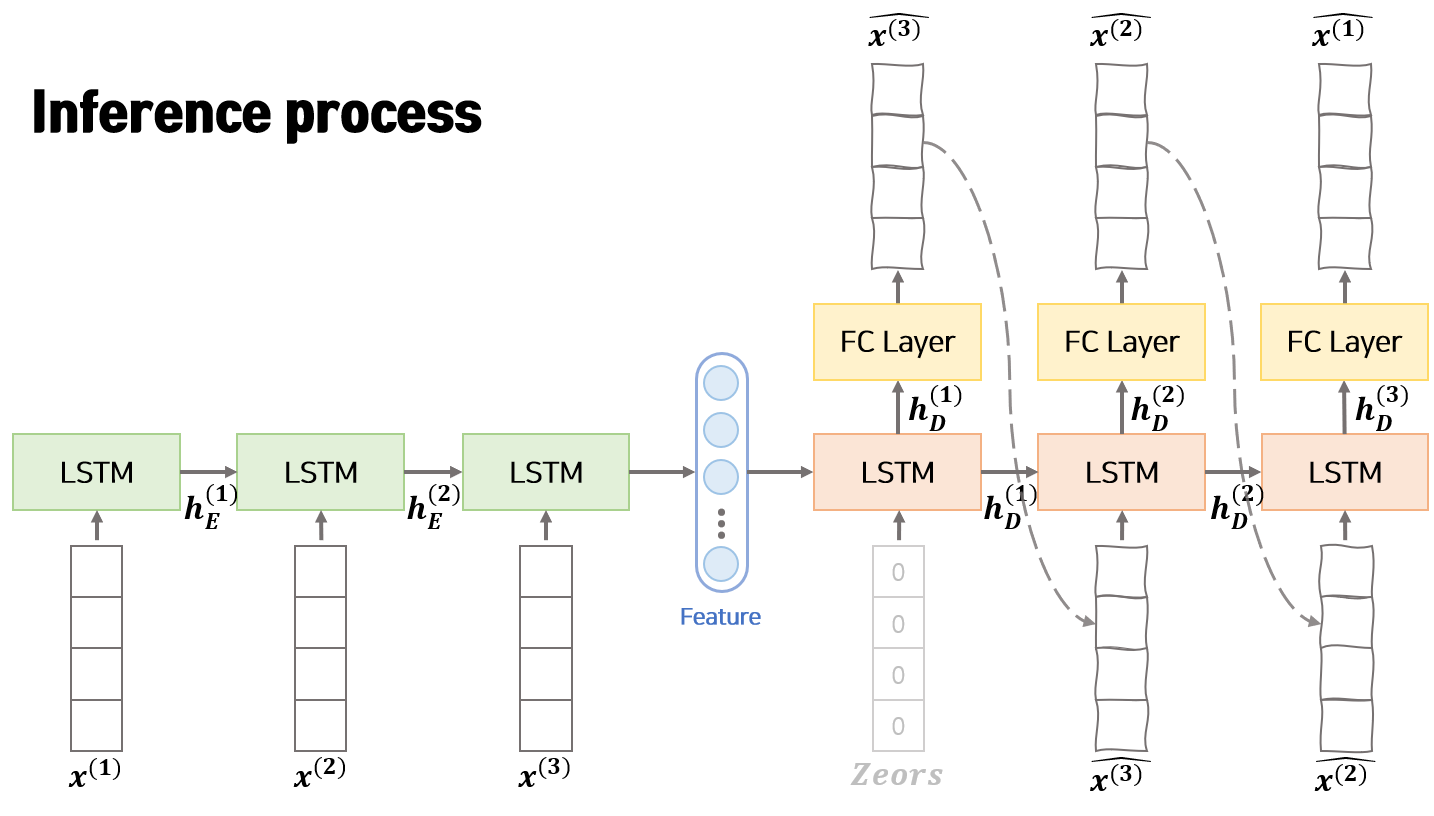

In [38]:
## LSTM Autoencoder

class Encoder(nn.Module):

    def __init__(self, input_size = 4096, hidden_size = 1024, num_layers = 2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True,
                            dropout = 0.1, bidirectional = False)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        return (hidden, cell)
    
class Decoder(nn.Module):

    def __init__(self, input_size = 4096, hidden_size = 1024, output_size = 4096, num_layers = 2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True,
                            dropout = 0.1, bidirectional = False)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)

        return prediction, (hidden, cell)
    
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int = 1,
                 **kwargs) -> None:

        super(LSTMAutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1

        self.encoder = Encoder(
            input_size = input_dim,
            hidden_size = latent_dim,
            num_layers = num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size = input_dim,
            output_size = input_dim,
            hidden_size = latent_dim,
            num_layers = num_layers,
        )

    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float)
        hidden = encoder_hidden
        
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        # MSE loss 사용
        loss = F.mse_loss(recons, input)
        return loss

In [39]:
def run(args, model, train_loader, test_loader):
   
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

    # 반복 횟수 Setting
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## 학습하기
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total = len(train_loader), desc = "training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total = len(test_loader), desc = "testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

def get_loss_list(args, model, test_loader):
    test_iterator = tqdm(enumerate(test_loader), total = len(test_loader), desc = "testing")
    loss_list = []
    
    with torch.no_grad():
        for i, batch_data in test_iterator:
                
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            
            ## MAE(Mean Absolute Error)로 계산
            loss = F.l1_loss(predict_values[0], predict_values[1], reduce=False)
            loss = loss.mean(dim = 1).cpu().numpy()
            loss_list.append(loss)
    loss_list = np.concatenate(loss_list, axis = 0)
    return loss_list

In [36]:
## Data Loader 형태로 변환
train_loader = torch.utils.data.DataLoader(
                 dataset = normal_dataset1,
                 batch_size = args.batch_size,
                 shuffle = True)
valid_loader = torch.utils.data.DataLoader(
                dataset = normal_dataset2,
                batch_size = args.batch_size,
                shuffle = False)

In [41]:
model = LSTMAutoEncoder(input_dim = args.input_size, latent_dim = args.latent_size, window_size = args.window_size, num_layers = args.num_layers)

In [42]:
## 학습하기
model = run(args, model, train_loader, valid_loader)

  0%|          | 0/9 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

In [43]:
# reconstruction error 계산
loss_list = get_loss_list(args, model, valid_loader)

# reconstruction Error의 평균과 공분산 계산
mean = np.mean(loss_list, axis = 0)
std = np.cov(loss_list.T)

testing:   0%|          | 0/161 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### **5. 결과** 

- 정상 데이터의 mean, std 계산 후 threshold 정의
- 전체 데이터에 대한 anomaly detect 구간 확인 

In [80]:
## Anomaly Score 정의
class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1]
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error - self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)

# mean, std 기반으로 anomaly score 계산  
anomaly_calculator = Anomaly_Calculator(mean, std)

In [68]:
# threshold 정의
anomaly_scores = []
for temp_loss in tqdm(loss_list):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

print("평균[{}], 중간[{}], 최소[{}], 최대[{}]".format(np.mean(anomaly_scores), np.median(anomaly_scores), np.min(anomaly_scores), np.max(anomaly_scores)))

  0%|          | 0/20581 [00:00<?, ?it/s]

평균[0.11485263362081999], 중간[0.06049511239606791], 최소[0.007760198505962193], 최대[5.926034418319065]


In [72]:
## 전체 데이터 불러오기
total_dataset = TagDataset(df = df, input_size = args.input_size, window_size = args.window_size, mean_df = mean_df, std_df = std_df)
total_dataloader = torch.utils.data.DataLoader(dataset = total_dataset, batch_size = args.batch_size, shuffle = False)

# reconstruction loss 계산
total_loss = get_loss_list(args, model, total_dataloader)

# anomaly score 계산
anomaly_scores = []
for temp_loss in tqdm(total_loss):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = total_dataset.df
visualization_df['score'] = anomaly_scores
visualization_df['recons_error'] = total_loss.sum(axis = 1)

testing:   0%|          | 0/1722 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/220318 [00:00<?, ?it/s]

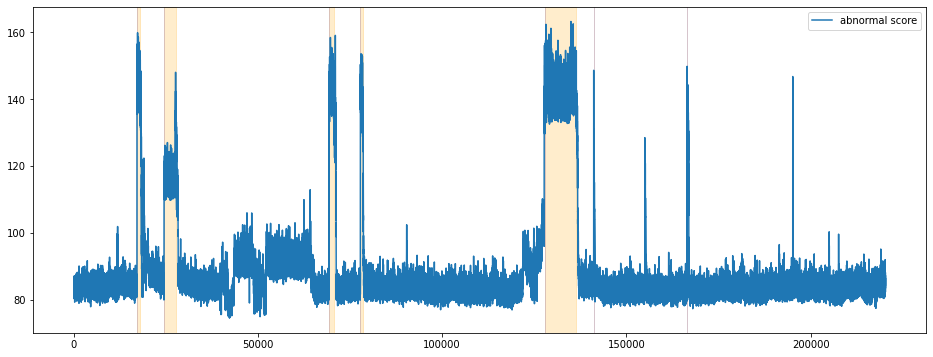

In [73]:
## 결과 시각화
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(111)

# 라벨 기준으로 불량 구간 정의 / 표시  
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index

visualization_df['score'].plot(ax = ax)
ax.legend(['abnormal score'], loc = 'upper right')

# 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha = 0.2, color = 'blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha = 0.2, color = 'orange')
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha = 0.2, color = 'blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha = 0.2, color = 'orange')

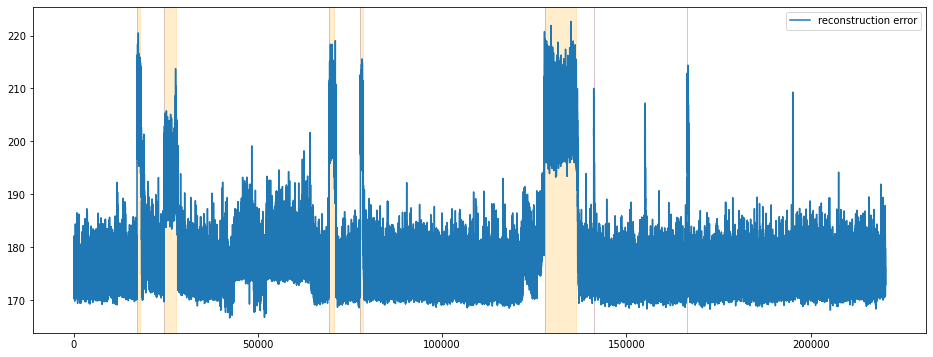

In [74]:
# 시각화 하기
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(111)

# 이상 구간 탐색
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index

visualization_df['recons_error'].plot(ax = ax)
ax.legend(['reconstruction error'], loc = 'upper right')

# 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha = 0.2, color = 'blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha = 0.2, color = 'orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha = 0.2, color = 'blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha = 0.2, color = 'orange')

### **6. 추가 모델: CNN-LSTM** 

- 모델 구조: CNN + LSTM

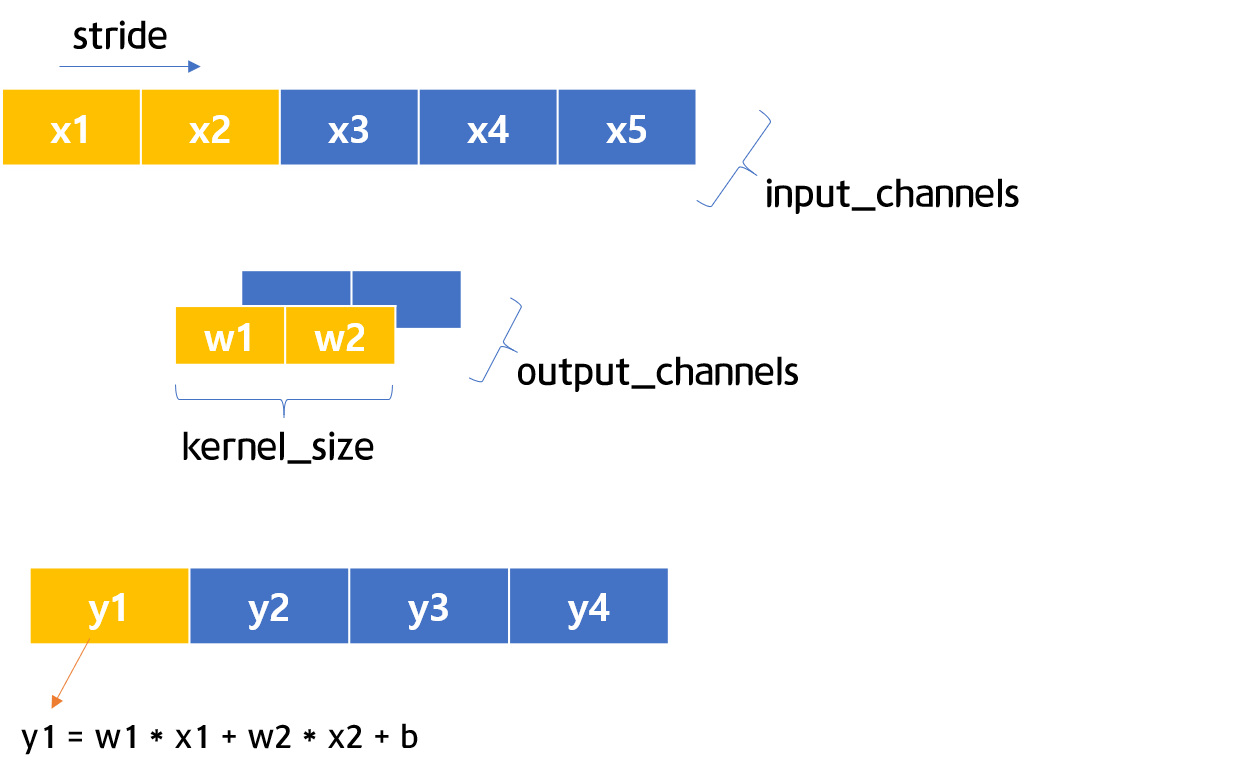

In [186]:
## 하이퍼 파라미터 설정
args = easydict.EasyDict({
    "batch_size": 128, # 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), # GPU 사용 여부 설정
    "input_size": 40, # 입력 차원 설정
    "latent_size": 10, # hidden 차원 설정
    "output_size": 40, # 출력 차원 설정
    "window_size" : 3, # sequence Lenght
    "num_layers": 1, # LSTM layer 수 설정
    "learning_rate" : 0.001, # learning rate 설정
    "max_iter" : 10000, # 총 반복 횟수 설정
    'early_stop' : False, # valid loss가 작아지지 않으면 early stop 조건 설정
})

In [194]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1):
        super(CNNLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.AvgPool1d(2)

        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout = 0.1, bidirectional = False)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.size(1)
        
        # (seq_len x batch_size x input_size) -> (batch_size x input_size x seq_len) for CNN
        inputs = inputs.transpose(0, 1).transpose(1, 2)
        c = self.c1(inputs)
        p = self.p1(c)

        # (batch_size x hidden_size x seq_len) -> (seq_len x batch_size x hidden_size) for LSTM
        p = p.transpose(1, 2).transpose(0, 1)
        
        p = F.tanh(p)
        output, hidden = self.lstm(p, hidden)
        conv_seq_len = output.size(0)
        output = output.view(conv_seq_len * batch_size, self.hidden_size) 
        output = F.tanh(self.out(output))
        output = output.view(conv_seq_len, -1, self.output_size)
        return output, hidden


    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        ## MSE loss(Mean squared Error)
        loss = F.mse_loss(recons, input)
        return loss

In [180]:
def Lcrun(args, model, train_loader, test_loader):
    
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    count = 0
    best_loss = 10000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total = len(train_loader), desc = "training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data
            predict_values, hidden = model(batch_data, None)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total = len(test_loader), desc = "testing")
        with torch.no_grad(): 
            for i, batch_data in test_iterator:
                
                batch_data = batch_data
                predict_value, hidden = model(batch_data, None)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

def get_loss_list(args, model, test_loader):
    test_iterator = tqdm(enumerate(test_loader), total = len(test_loader), desc = "testing")
    loss_list = []
    
    with torch.no_grad():
        for i, batch_data in test_iterator:
                
            batch_data = batch_data
            predict_values, hidden = model(batch_data, None)
            
            ## MAE(Mean Absolute Error)로 계산
            loss = F.l1_loss(predict_values[0], predict_values[1], reduce = False)
            loss = loss.mean(dim = 1).cpu().numpy()
            loss_list.append(loss)
    loss_list = np.concatenate(loss_list, axis = 0)
    return loss_list

In [187]:
## 모델 생성
model = CNNLSTM(args.input_size, args.latent_size, args.output_size, args.num_layers)
model

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CNNLSTM(
  (c1): Conv1d(40, 10, kernel_size=(2,), stride=(1,))
  (p1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (lstm): LSTM(10, 10, dropout=0.1)
  (out): Linear(in_features=10, out_features=40, bias=True)
)

In [188]:
model = Lcrun(args, model, train_loader, valid_loader)

  0%|          | 0/9 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

testing:   0%|          | 0/161 [00:00<?, ?it/s]

training:   0%|          | 0/1126 [00:00<?, ?it/s]

In [189]:
# reconstruction error 계산
loss_list_cnn = get_loss_list(args, model, valid_loader)

# reconstruction Error의 평균과 공분산 계산
mean_cnn = np.mean(loss_list_cnn, axis = 0)
std_cnn = np.cov(loss_list_cnn.T)

testing:   0%|          | 0/161 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
